# 02.00-maj-logistic-regression.ipynb
Mitchell Joseph
<br>Created: 2022-11-22</br>
Last Modified: 2022-11-22

Using the dataset `../data/01-external/test_scores.csv` created in notebook 01.01-maj. We explore a simple logistic regression model using just SAT scores to predict whether a student was admitted to their first choice school.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

import stan
import nest_asyncio
nest_asyncio.apply()

In [2]:
df = pd.read_csv("../data/01-raw/test_scores.csv")

In [3]:
df.head()

,SUBJID,SATMath,SATWriting,SATVerbal,State,Yoursex:,Race/EthnicityGroup,CHOICE,ACCPT1ST
0,884230,450,420,430,AL,Female,Black,4.0,1.0
1,884232,430,430,470,AL,Male,Black,1.0,1.0
2,884233,430,320,320,AL,Male,Black,4.0,0.0
3,884247,560,540,580,AL,Female,Black,1.0,1.0
4,884266,440,400,410,AL,Female,Two or more race/ethnicity,3.0,1.0


In [4]:
X = df[['SATMath', 'SATWriting', 'SATVerbal']].copy().to_numpy()
Y = df['ACCPT1ST'].copy().astype(np.int8).to_numpy()

## Model

We have that $y \in {0,1}$ and $x_i \in \mathbb{R}^{k+1}$

\begin{align*}
y_i &\sim \rm Bernoulli(p_i) \\
g(p_i) &= \eta_i = \sum_{i=1}^k x_{ij} \beta_j \\
\beta_j &\sim \rm Normal(0,3)
\end{align*}

In [5]:
# Normalize the data
n = X.shape[0]
k = X.shape[1]
X_std = np.zeros((n,k))
for i in range(k):
    X_std[:, i] = (X[:,i] - X[:,i].mean()) / X[:, i].std()
X_std = np.concatenate((np.ones((n,1)), X_std), axis=1)

In [6]:
model_code = """
data {
  int<lower=0> n;                // number of units
  int<lower=0> k;                // number of covariates
  matrix[n, k + 1] X;            // covariates for each entry, including the intercept covariate
  array[n] int <lower=0,upper=1> Y;     // binary responses

  int do_prior_predictive;
}
parameters {
  vector[k + 1] beta;            // the coefficients
}
transformed parameters {
  vector[n] eta;                // linear predictors
  eta = X * beta;
}
model {
  beta ~ normal(0, 3);

  if (do_prior_predictive != 1) {
    Y ~ bernoulli_logit(eta);
  }
}
generated quantities {
  array[n] int <lower=0,upper=1> Y_tilde;
  Y_tilde = bernoulli_logit_rng(eta);  
}
"""

## Prior predictive

In [7]:
model = stan.build(model_code, data={'n':n, 'k':k, 'X':X_std, 'Y':Y, 'do_prior_predictive':1})

Building...



Building: found in cache, done.

In [8]:
fit = model.sample()

Sampling:   0%
Sampling:   8% (600/8000)
Sampling:  12% (1000/8000)
Sampling:  15% (1200/8000)
Sampling:  18% (1400/8000)
Sampling:  20% (1600/8000)
Sampling:  22% (1800/8000)
Sampling:  23% (1801/8000)
Sampling:  25% (2002/8000)
Sampling:  29% (2302/8000)
Sampling:  31% (2502/8000)
Sampling:  35% (2801/8000)
Sampling:  36% (2902/8000)
Sampling:  41% (3303/8000)
Sampling:  49% (3903/8000)
Sampling:  50% (4004/8000)
Sampling:  51% (4103/8000)
Sampling:  53% (4202/8000)
Sampling:  54% (4301/8000)
Sampling:  55% (4400/8000)
Sampling:  56% (4500/8000)
Sampling:  58% (4600/8000)
Sampling:  59% (4700/8000)
Sampling:  60% (4800/8000)
Sampling:  61% (4900/8000)
Sampling:  62% (5000/8000)
Sampling:  64% (5100/8000)
Sampling:  65% (5200/8000)
Sampling:  66% (5300/8000)
Sampling:  68% (5400/8000)
Sampling:  69% (5500/8000)
Sampling:  70% (5600/8000)
Sampling:  71% (5700/8000)
Sampling:  72% (5800/8000)
Sampling:  74% (5900/8000)
Sampling:  75% (6000/8000)
Sampling:  76% (6100/8000)
Sampling:  78%

In [9]:
fit.to_frame()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,beta.1,beta.2,beta.3,...,Y_tilde.98505,Y_tilde.98506,Y_tilde.98507,Y_tilde.98508,Y_tilde.98509,Y_tilde.98510,Y_tilde.98511,Y_tilde.98512,Y_tilde.98513,Y_tilde.98514
draws,,,,,,,,,,,,,,,,,,,,,
0,-3.023660,0.690263,0.742614,2.0,3.0,0.0,6.556990,-5.108872,2.038801,-2.694353,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-1.319642,0.979639,0.737945,3.0,7.0,0.0,2.661239,0.355564,4.194179,-1.786306,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
2,-3.261567,0.756633,0.828946,3.0,7.0,0.0,6.015000,-6.284004,-1.652163,3.351158,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-1.782615,0.994419,0.764448,2.0,3.0,0.0,3.916548,1.565368,2.748673,4.491274,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,-1.112589,0.730639,0.742614,3.0,7.0,0.0,7.901607,-1.520684,-2.484631,-3.395776,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-1.876960,0.999026,0.764448,3.0,7.0,0.0,2.375663,1.978439,1.104630,5.180155,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
3996,-0.983310,1.000000,0.742614,2.0,3.0,0.0,3.642623,2.387781,0.625485,-1.861190,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
3997,-2.379416,0.930512,0.737945,1.0,1.0,0.0,2.552445,2.438662,-3.279693,4.996673,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [10]:
az_fit = az.from_pystan(fit)

In [11]:
np.sum(np.array(az_fit.sample_stats['diverging']))

0

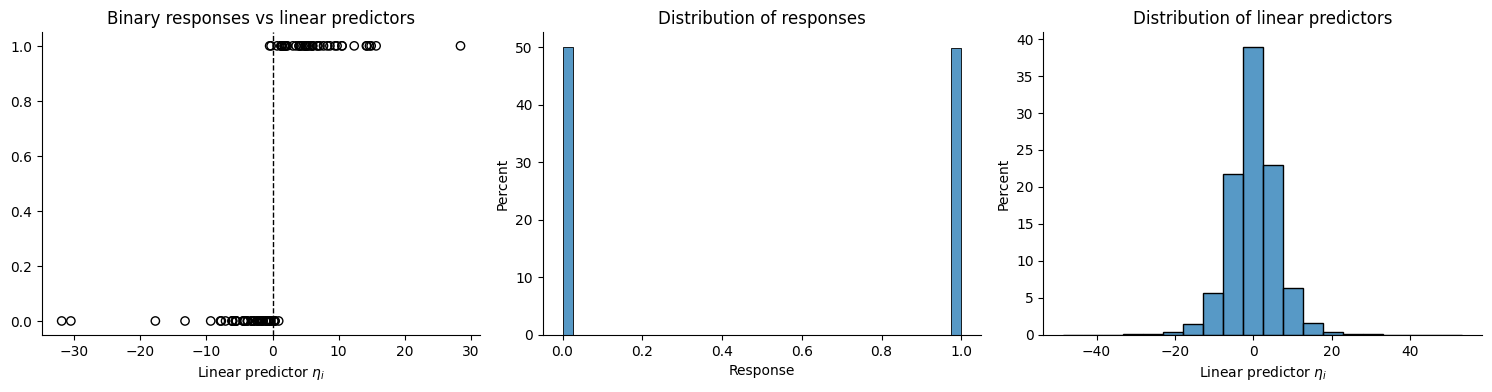

In [16]:
# Visualize prior predictive
plt.figure(figsize=(15, 4))
n_rows, n_cols = fit['eta'].shape

plt.subplot(131)
plt.title('Binary responses vs linear predictors')
for sample_idx in range(10):
  # choose a random sample
  sample_col = np.random.randint(0, n_cols)
  sample_rows = np.random.choice(n_rows, size=10, replace=False)
  x = fit['eta'][sample_rows, sample_col]
  y = fit['Y_tilde'][sample_rows, sample_col]
  plt.scatter(x, y, c='none', edgecolors='k')
sns.despine()
plt.axvline(0, c='k', lw=1, ls='--')
plt.xlabel('Linear predictor $\eta_i$')

plt.subplot(132)
row_idx = np.random.choice(n_rows, size=100, replace=False)
plt.title('Distribution of responses')
sns.histplot(fit['Y_tilde'][row_idx, :].flatten(), stat='percent')
sns.despine()
plt.xlabel('Response')

plt.subplot(133)
sns.histplot(fit['eta'][row_idx, :].flatten(), bins=20, stat='percent')
sns.despine()
plt.xlabel('Linear predictor $\eta_i$')
plt.title('Distribution of linear predictors')

plt.tight_layout(pad=1)

# Posterior fit

In [7]:
model = stan.build(model_code, data={'n':n, 'k':k, 'X':X_std, 'Y':Y, 'do_prior_predictive':0})

Building...



Building: found in cache, done.

In [8]:
fit = model.sample()

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   1% (102/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Sampl

In [9]:
fit.to_frame()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,beta.1,beta.2,beta.3,...,Y_tilde.98505,Y_tilde.98506,Y_tilde.98507,Y_tilde.98508,Y_tilde.98509,Y_tilde.98510,Y_tilde.98511,Y_tilde.98512,Y_tilde.98513,Y_tilde.98514
draws,,,,,,,,,,,,,,,,,,,,,
0,-59463.612788,0.958156,0.373301,3.0,7.0,0.0,59464.519497,0.849392,-0.233002,-0.162796,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,-59464.003816,1.000000,0.444969,3.0,7.0,0.0,59467.528870,0.853526,-0.239738,-0.157056,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
2,-59462.889563,1.000000,0.362697,3.0,7.0,0.0,59464.062130,0.860402,-0.216969,-0.155939,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,-59464.726882,0.964634,0.436199,2.0,3.0,0.0,59465.001491,0.850620,-0.240087,-0.148937,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
4,-59463.668645,0.991636,0.373301,3.0,7.0,0.0,59464.370583,0.851616,-0.236720,-0.160110,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-59462.918136,0.981353,0.436199,2.0,7.0,0.0,59466.599602,0.860268,-0.226584,-0.144972,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
3996,-59466.089213,0.996800,0.373301,3.0,7.0,0.0,59466.314501,0.855254,-0.242309,-0.144047,...,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
3997,-59463.179618,0.987822,0.444969,2.0,3.0,0.0,59463.931491,0.856748,-0.215264,-0.173994,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0


In [11]:
az_fit = az.from_pystan(fit)

In [12]:
np.sum(np.array(az_fit.sample_stats['diverging']))

0

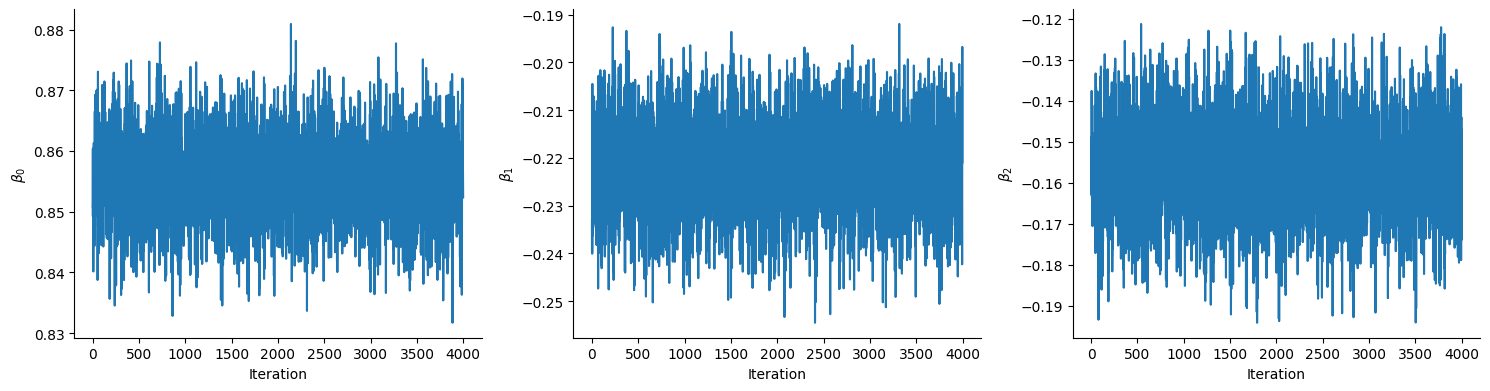

In [13]:
plt.figure(figsize=(15, 4))

for j in range(3):
  plt.subplot(1, 3, j + 1)
  plt.plot(fit['beta'][j,:])
  sns.despine()
  plt.xlabel('Iteration')
  plt.ylabel(r'$\beta_' + str(j) + '$')
  
plt.tight_layout(pad=1)

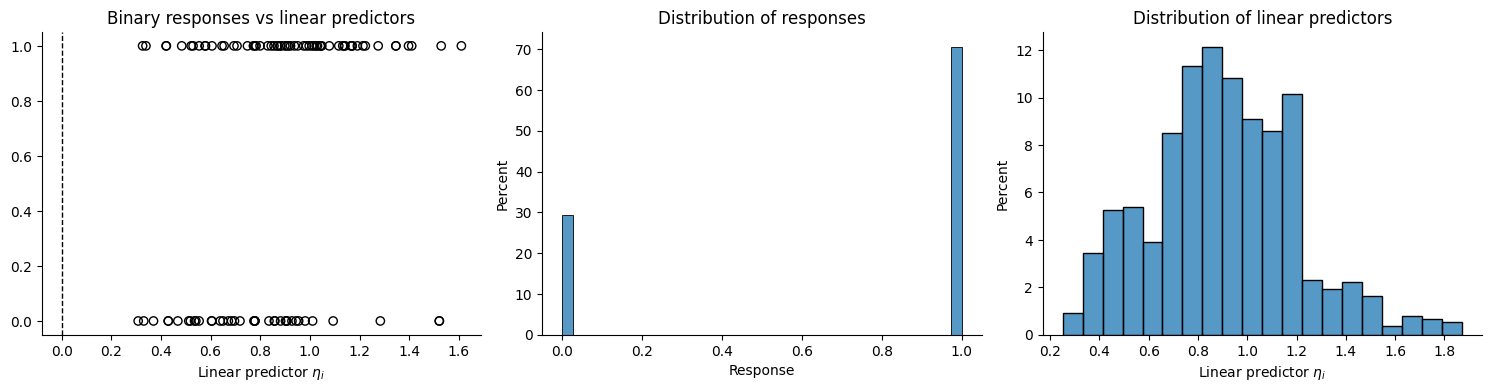

In [14]:
# Visualize prior predictive
plt.figure(figsize=(15, 4))
n_rows, n_cols = fit['eta'].shape

plt.subplot(131)
plt.title('Binary responses vs linear predictors')
for sample_idx in range(10):
  # choose a random sample
  sample_col = np.random.randint(0, n_cols)
  sample_rows = np.random.choice(n_rows, size=10, replace=False)
  x = fit['eta'][sample_rows, sample_col]
  y = fit['Y_tilde'][sample_rows, sample_col]
  plt.scatter(x, y, c='none', edgecolors='k')
sns.despine()
plt.axvline(0, c='k', lw=1, ls='--')
plt.xlabel('Linear predictor $\eta_i$')

plt.subplot(132)
row_idx = np.random.choice(n_rows, size=100, replace=False)
plt.title('Distribution of responses')
sns.histplot(fit['Y_tilde'][row_idx, :].flatten(), stat='percent')
sns.despine()
plt.xlabel('Response')

plt.subplot(133)
sns.histplot(fit['eta'][row_idx, :].flatten(), bins=20, stat='percent', label='Posterior Pred.')
sns.despine()
plt.xlabel('Linear predictor $\eta_i$')
plt.title('Distribution of linear predictors')

plt.tight_layout(pad=1)